#### Carregamento de dados

In [1]:
%run bot_libraries.ipynb

In [2]:
data = pd.read_csv("CryptoBot_202103006Mv001.csv")

In [3]:
%run tratamento_de_dados.ipynb

#### Gráfico 'Open', 'High', 'Low', 'Close'

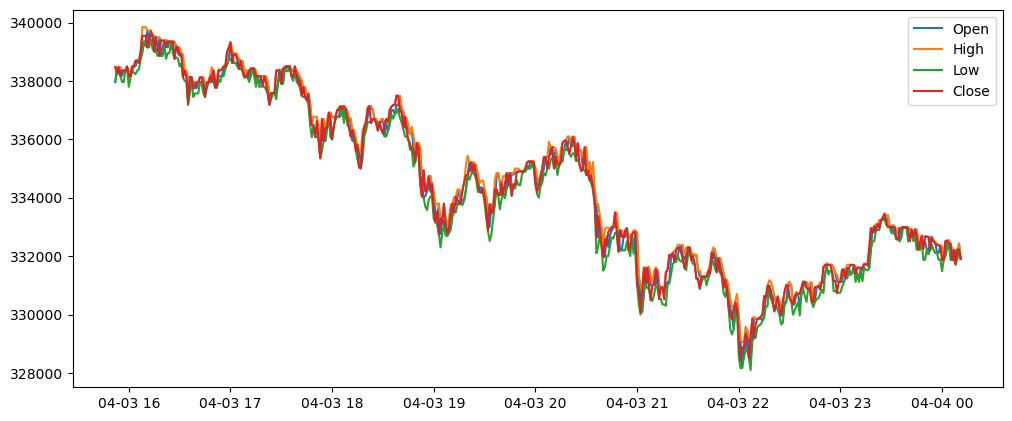

In [4]:
from matplotlib.pyplot import legend
from matplotlib import pylab
data_0 = data[['Open', 'High', 'Low', 'Close']]
plt.figure(figsize=(12,5), dpi=100)
line = plt.plot(data.index, data_0)
plt.legend(line, data_0.columns)

In [5]:
data = data*10**10

##### 5.1.1. BBANDS - Bollinger Bands
Learn more about the Bollinger Bands at tadoc.org.

In [6]:
upperband, middleband, lowerband = talib.BBANDS(np.array(data['Close']), timeperiod=21, nbdevup=1.7, nbdevdn=1.7, matype=0)

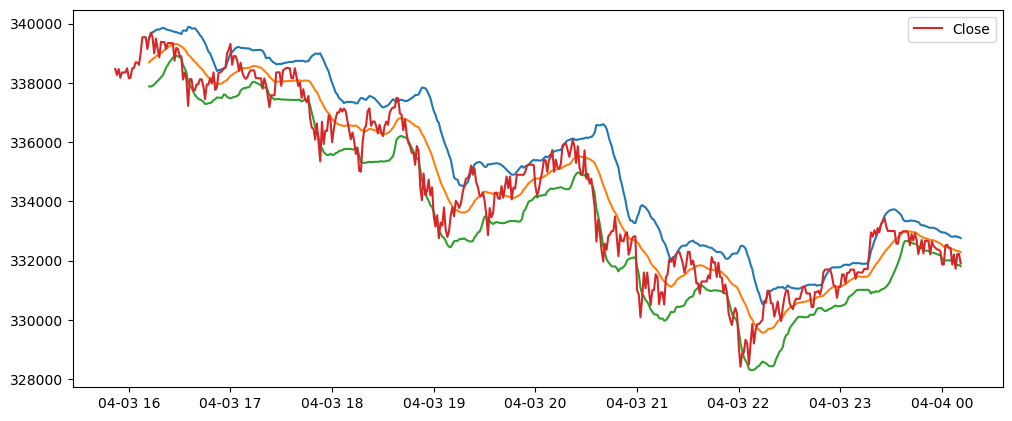

In [7]:
#Bordas de Boillinger
data_Boillinger = pd.DataFrame({"Upperband": upperband/10**10, "Middleband":middleband/10**10, "Lowerband":lowerband/10**10})

data_0 = data_Boillinger[["Upperband", "Middleband", "Lowerband"]]
plt.figure(figsize=(12,5), dpi=100)
line = plt.plot(data.index, data_0)


#Preço
data_p = pd.DataFrame()
data_p['Close'] = data['Close']/(10**10)

line_p = plt.plot(data_p.index, data_p)


plt.legend(line, data_0.columns)
plt.legend(line_p, data_p.columns)
plt.show()

#### Dataframe

In [8]:
data = data/(10**10)

In [9]:
df_BB = pd.DataFrame()
for i in range(len(data)):
    df_BB = df_BB.append({"Close": data['Close'][i], "Upperband":upperband[i]/(10**10), "Middleband":middleband[i]/(10**10), "Lowerband":lowerband[i]/(10**10)}, ignore_index = True)

In [10]:
df_BB_drop = df_BB.dropna().reset_index(drop = True)
df_BB_drop

,Close,Lowerband,Middleband,Upperband
0,339524.0000000000,337889.0719945146,338695.6666666666,339502.2613388188
1,339700.0000000000,337875.0503492107,338754.0952380953,339633.1401269798
2,339545.0000000000,337911.2763133940,338814.7142857143,339718.1522580346
3,339001.0000000000,337943.7102051965,338839.8571428572,339736.0040805179
4,339499.0000000000,338013.6155593302,338902.8571428572,339792.0987263842
...,...,...,...,...
475,332210.0000000000,331949.9643066346,332380.3809523809,332810.7975981273
476,331730.0000000000,331856.5203986827,332345.2380952381,332833.9557917935
477,332221.0000000000,331851.1055672272,332322.4285714285,332793.7515756299
478,332227.0000000000,331849.9371727936,332321.6666666666,332793.3961605398


#### Loop de descisão de compra com Bordas de Bollinger

In [11]:
df_BBANDS_score = df_BB
# Todos os valores estão em reais
M_0 = 100.0

Montante_reais = M_0/2 # Fração do montante na primeira moeda do par
Montante_crypto = M_0/2/df_BBANDS_score["Close"][0] # Fração da criptomoeda correspondente ao complemento do investimento inicial.
                                                    # É o valor em reais dividido pelo valor de fechamento da criptomoeda no momento da compra.
Montante_total = M_0
df_BBANDS_score["Upper Touch"] = 0.0
df_BBANDS_score["Down Touch"] = 0.0
df_BBANDS_score["Ganho [%]"] = 0.0
df_BBANDS_score["Montante_total"] = Montante_total
change = ""
last_change = "" # Toque inicial na linha de Boilliger é vazio
band_count = 0
for i in range(len(df_BBANDS_score)):
    
    last_change = change
    Montante_total = Montante_reais + Montante_crypto*df_BBANDS_score['Close'][i]
    df_BBANDS_score["Montante_total"][i] = Montante_total
    df_BBANDS_score["Ganho [%]"][i] = (Montante_total - M_0)/M_0*100
    if (df_BBANDS_score['Close'][i] - df_BBANDS_score['Upperband'][i])>0.0:
        df_BBANDS_score["Upper Touch"][i] = 1
        change = "UP"
        
    if ((df_BBANDS_score['Close'][i] - df_BBANDS_score['Lowerband'][i])<0.0):
        df_BBANDS_score["Down Touch"][i] = 1
        change = "DOWN"
    
    if (last_change != change):
        if (last_change == "UP"):
            venda_cripto = 0.03*Montante_crypto*df_BBANDS_score['Close'][i] # Venda das criptos em reais
            Montante_crypto -= 0.03*Montante_crypto # Diminui o montante de crypto moedas
            Montante_reais += venda_cripto # Aumenta o montante de reais
        if (last_change == "DOWN"):
            compra_cripto = 0.03*Montante_reais
            Montante_reais -= compra_cripto
            Montante_crypto += compra_cripto/df_BBANDS_score['Close'][i]
        #Conta o número de mudanças entre compra e venda de acordo com os toques alternados nas Bordas de Boillinger
        band_count += 1 



In [12]:
Montante_total

99.0418998267464

In [13]:
df_BBANDS_score

,Close,Lowerband,Middleband,Upperband,Upper Touch,Down Touch,Ganho [%],Montante_total
0,338473.0000000000,nan,nan,nan,0.0000000000,0.0000000000,0.0000000000,100.0000000000
1,338272.0000000000,nan,nan,nan,0.0000000000,0.0000000000,-0.0296921763,99.9703078237
2,338473.0000000000,nan,nan,nan,0.0000000000,0.0000000000,0.0000000000,100.0000000000
3,338176.0000000000,nan,nan,nan,0.0000000000,0.0000000000,-0.0438735143,99.9561264857
4,338357.0000000000,nan,nan,nan,0.0000000000,0.0000000000,-0.0171357834,99.9828642166
...,...,...,...,...,...,...,...,...
495,332210.0000000000,331949.9643066346,332380.3809523809,332810.7975981273,0.0000000000,0.0000000000,-0.9141101285,99.0858898715
496,331730.0000000000,331856.5203986827,332345.2380952381,332833.9557917935,0.0000000000,1.0000000000,-0.9833403629,99.0166596371
497,332221.0000000000,331851.1055672272,332322.4285714285,332793.7515756299,0.0000000000,0.0000000000,-0.9125236023,99.0874763977
498,332227.0000000000,331849.9371727936,332321.6666666666,332793.3961605398,0.0000000000,0.0000000000,-0.9116582244,99.0883417756
